In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_path = "/content/drive/My Drive/Datasets/Pubg/train_V2.csv"
train = pd.read_csv(train_path)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

## Exploring the columns 
* groupId: Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a `different` groupId each time
* matchId: Integer ID to identify match
* assists: Number of enemy players this player damaged that were killed by his teammates
* boosts: Number of boost items used
* DamageDealt: Total damage dealt. `Self inflicted damage is subtracted`
* DBNOs: Number of enemy player knocked
* headshotKills: Number of enemy killed by headshots
* heals: number of healing items used
* KillPlace: Ranking in match of number of enemy players killed.
* killPoints: Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
* kills: Number of enemy players killed.
* killStreaks: Max number of enemy players killed in a short amount of time.
* longestKill: Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
* maxPlace: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* numGroups: Number of groups we have data for in the match.
* revives: Number of times this player revived teammates.
* rideDistance: Total distance traveled in vehicles measured in meters.
* roadKills: Number of kills while in a vehicle.
* swimDistance: Total distance traveled by swimming measured in meters.
* teamKills: Number of times this player killed a teammate.
* vehicleDestroys: Number of vehicles destroyed.
* walkDistance: Total distance traveled on foot measured in meters.
* weaponsAcquired: Number of weapons picked up.
* winPoints: Win-based external ranking of player. (Think of this as an Elo  ranking where only winning matters.)
* winPlacePerc: The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [5]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [6]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


## The Killers. Some noob some pro


In [7]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(train["kills"].mean(),train["kills"].quantile(0.99),train["kills"].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


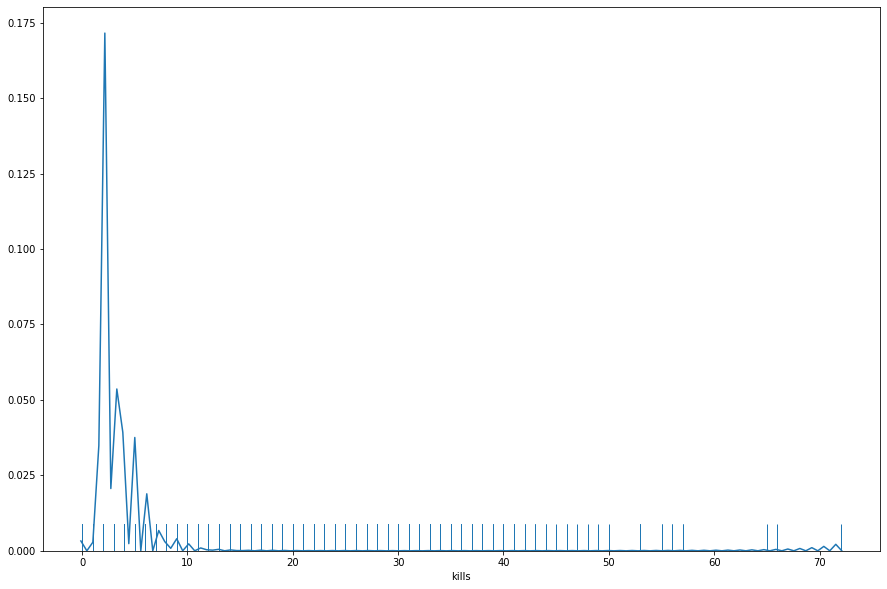

In [8]:
plt.figure(figsize=(15,10))
sns.distplot(train['kills'],rug=True,hist=False)
plt.show()

The distribution of kills isn't very good at all as some players have a very good kills but many players just aren't that good and  the average shows how less the kills are of players


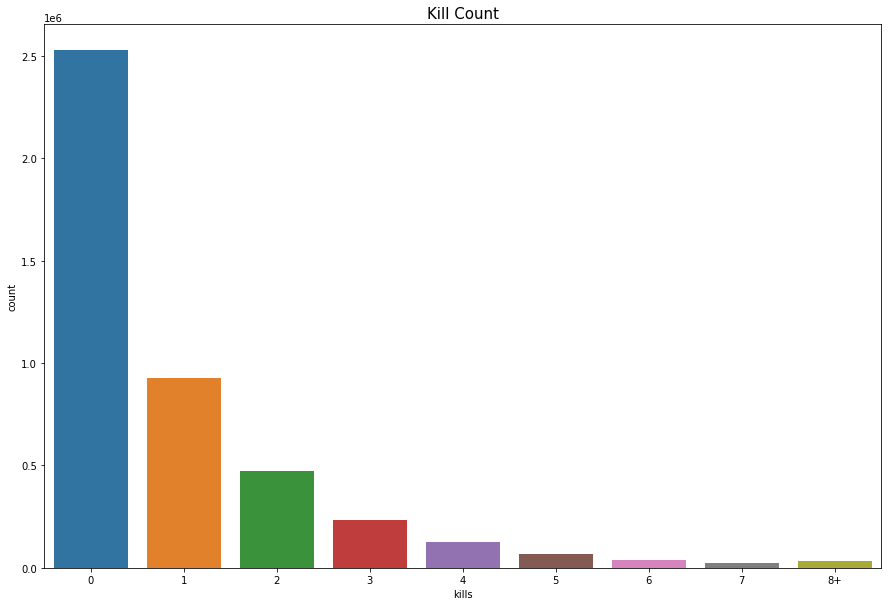

In [9]:
data = train.copy()
data.loc[data["kills"]>data["kills"].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data["kills"].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

Most people can't get one kill. I know one of them
It's `Saad bhai`

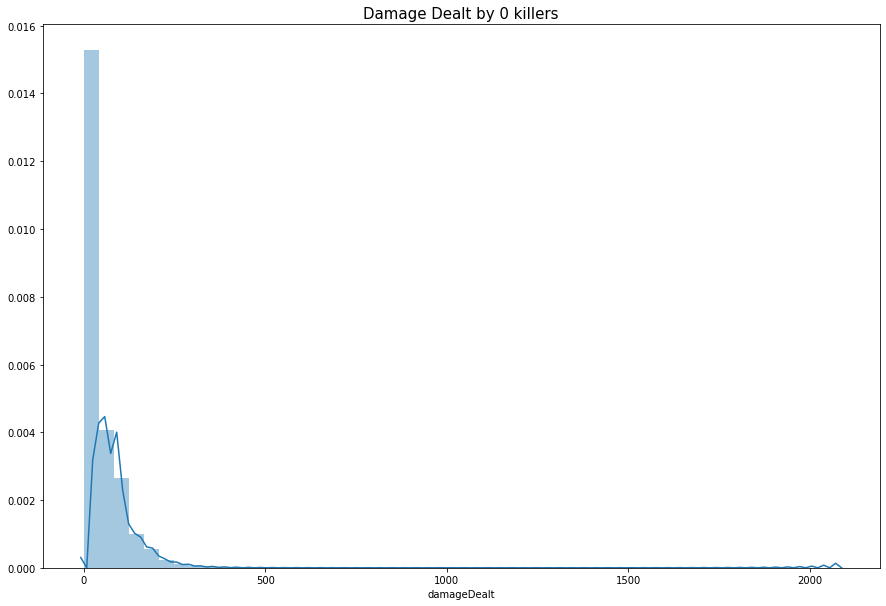

In [10]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

Well most of the players don't do damage at all. Seems like they just drop at pochinki and were unlucky that someone landed earlier and found a gun or they had a laggy start and got killed before being settled. 
Now i can explore some `exceptions`

In [11]:
print("{} players ({:.4f}%) have won without killing one enemy".format(len(data[data['winPlacePerc']==1]),100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt']==0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]),100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 players (0.3748%) have won without killing one enemy
4770 players (0.1073%) have won without dealing damage!


plotting win placement percentage vs kills

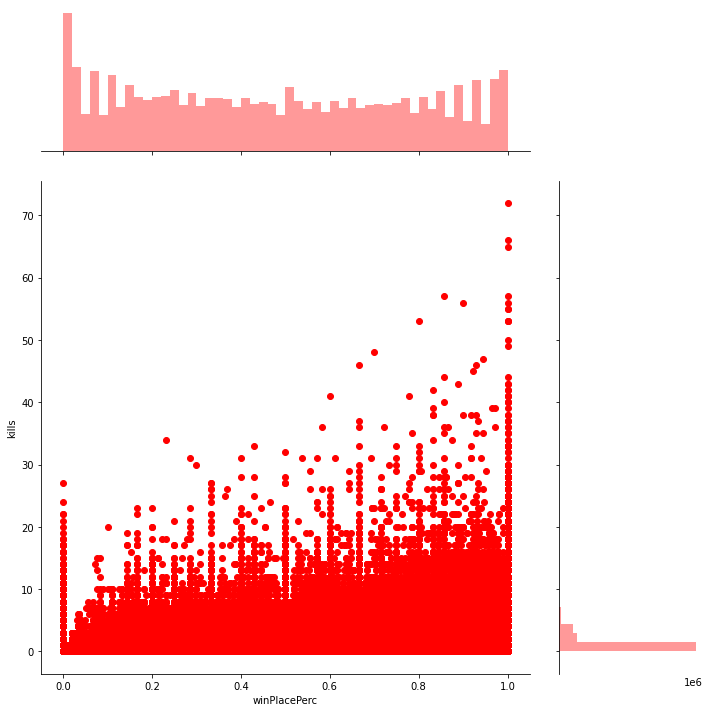

In [12]:
sns.jointplot(x="winPlacePerc",y="kills",data=train,height=10,ratio=3,color='r')
plt.show()

Wow killing has a relation with winning. It makes sense why Shroud won so many matches by killing 20 players in a match and I didn't got many since I used to go prone in final 10 

Grouping players based on kills


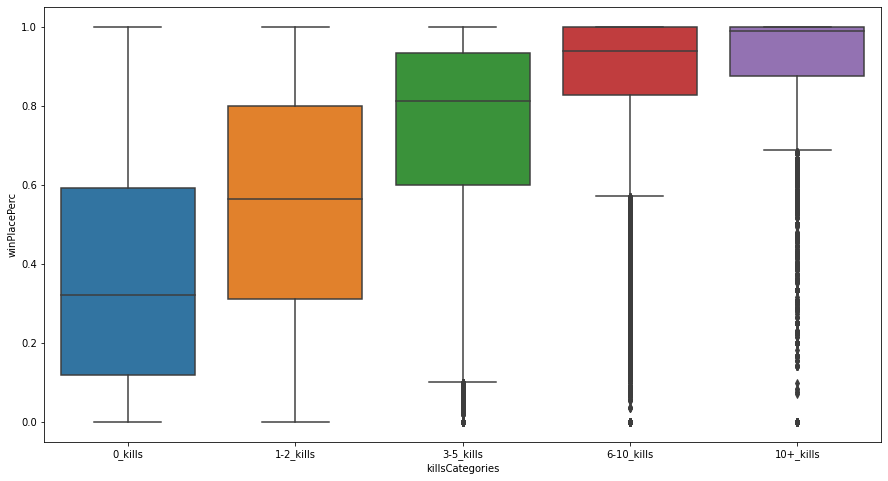

In [13]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

## Runners

One thing we all hate in pubg is to just run around places especially when you have to get into the safe zone and the blue zone is right behind you chasing to drain your health. It's safe to say pubg players have run much more in game than in real life and the stats can show why

In [14]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

The average person walks for 1154.2m, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25780.0m.


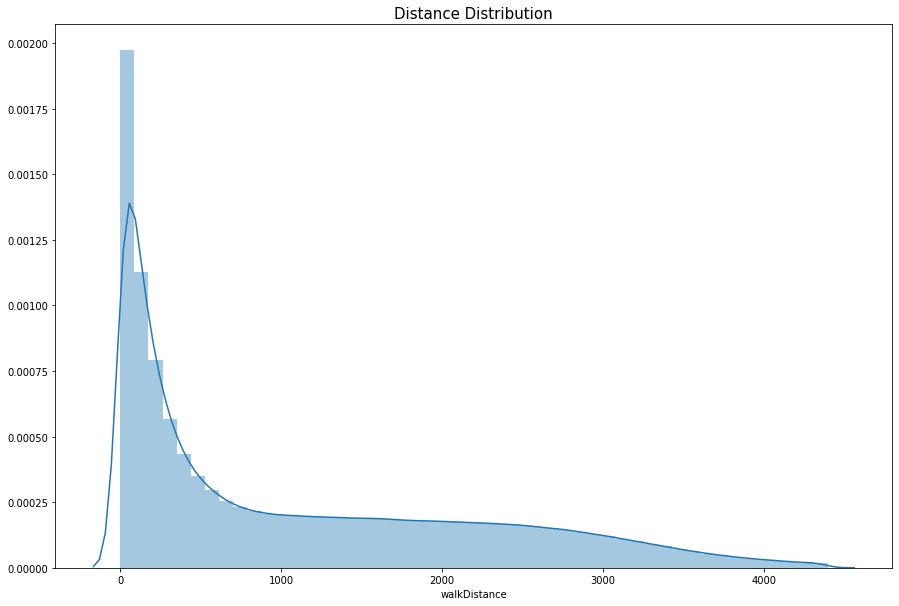

In [15]:
data = train.copy()
data = data[data['walkDistance']<train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [16]:
print("{} players ({:.4f}%) walked 0 meters which means they died without taking a single step.".format(len(data[data['walkDistance']==0]),100*len(data1[data1['walkDistance']==0])/len(train)))

99603 players (2.0329%) walked 0 meters which means they died without taking a single step.


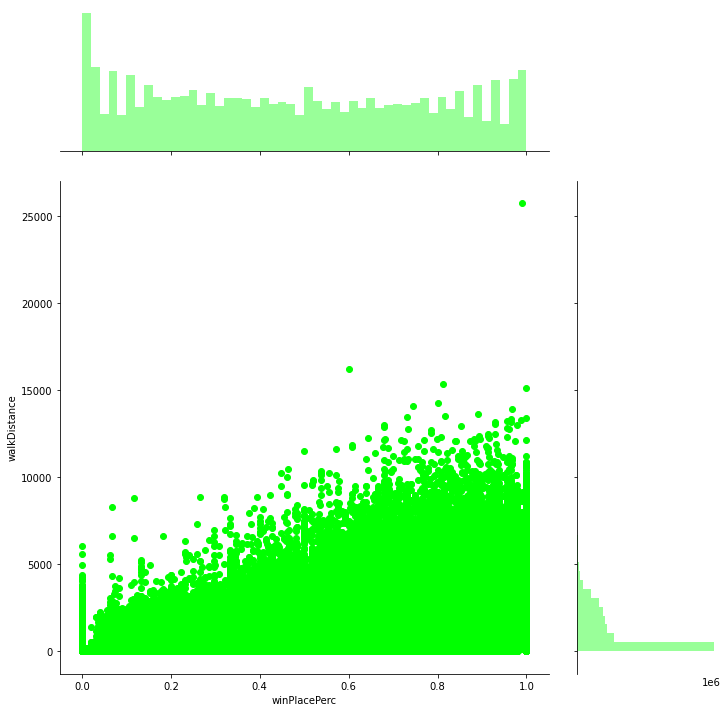

In [17]:
sns.jointplot(x="winPlacePerc",y="walkDistance",data=train,height=10,ratio=3,color="lime")
plt.show()

## Drivers

In [18]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the champions drived for {}m.".format(train['rideDistance'].mean(),train['rideDistance'].quantile(0.99),train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the champions drived for 40710.0m.


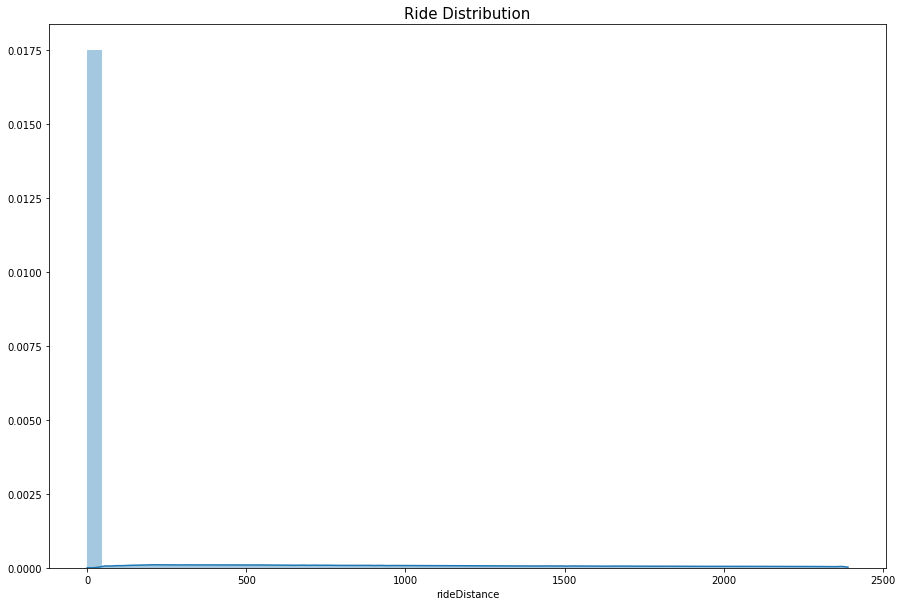

In [19]:
data = train.copy()
data = data[data['rideDistance']<train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

<Figure size 1080x720 with 0 Axes>

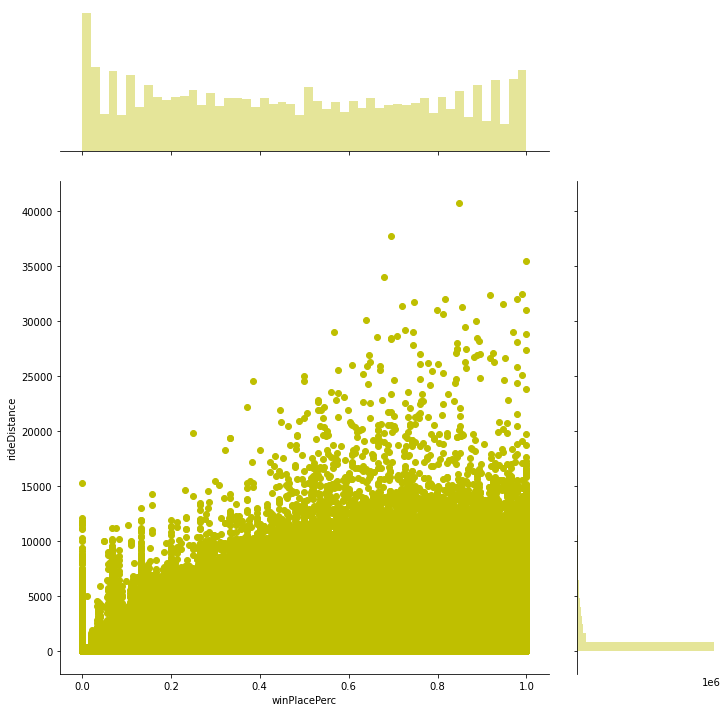

In [20]:
plt.figure(figsize=(15,10))
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color="y")
plt.show()

There is a little correlation between the distance travelled and matches won

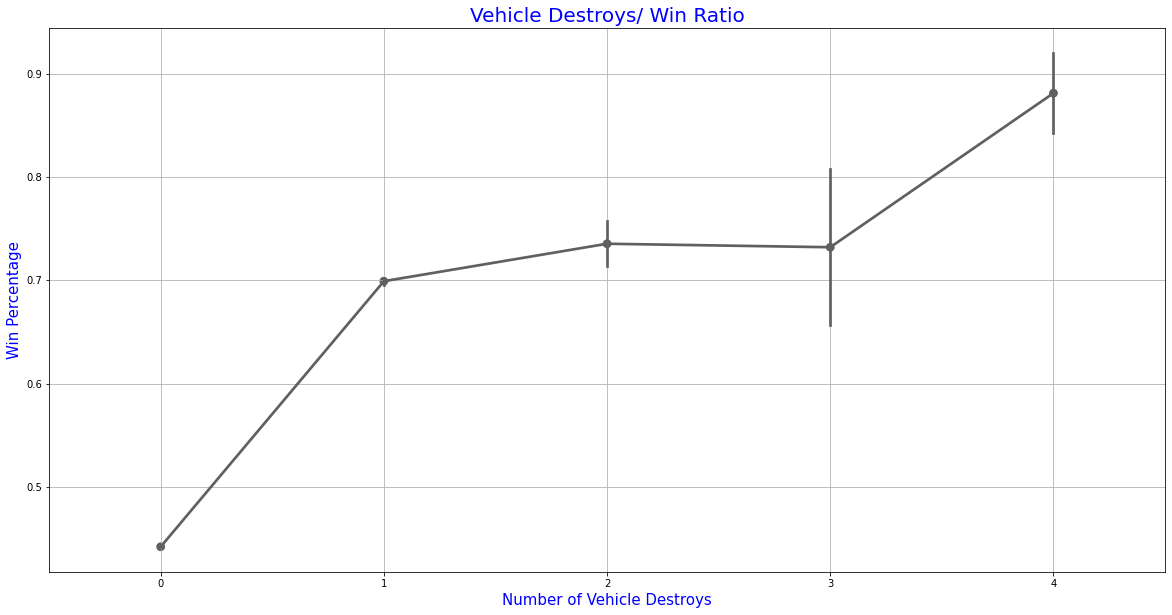

In [21]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

Destroying vehicles increase your chances of winning of a match so next time wehen you are crossing a bridge and fear someone will chase you just destroy the vehicles near-by or you are near a drop and see another vehicle approaching towards the drop. Destroy the car first then loot the drop

##Swimmers

Whenever you are playing in squad and you are the only one left and see bridge campers waiting for you to pass by the bridge. There is always an inner michael phelps inside of you that awakes and you choose to swim by the river to cross the bridge or you simply swim accross lands to avoid drama 

In [22]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

The average person swims for 4.5m, 99% of people have swimemd 123.0m or less, while the olympic champion swimmed for 3823.0m.


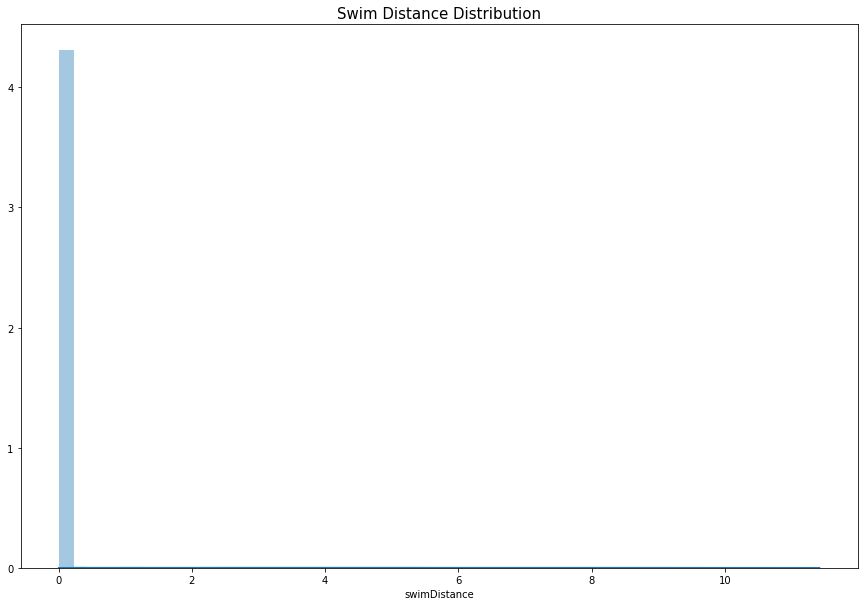

In [23]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

Distribution shows that close to no one swims. So, I'm gonna have to categorized them

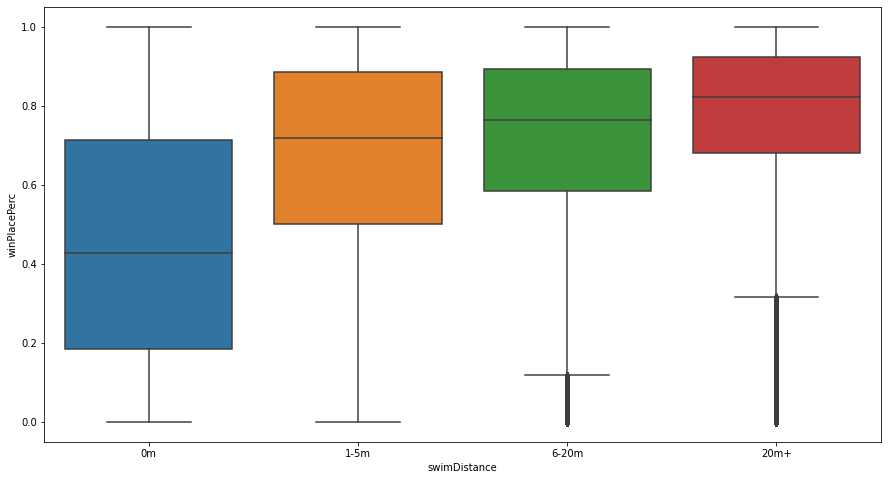

In [24]:
swim = train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

Analysis on this is a bit trouble because pubg has 4 maps and 2 of them have no water. So analysis can be done later on different maps

## Healers

If you are a player who rushes always towards the enemy then you need alot of meds with you and 15 to 20% of your game spend in using meds 

In [25]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


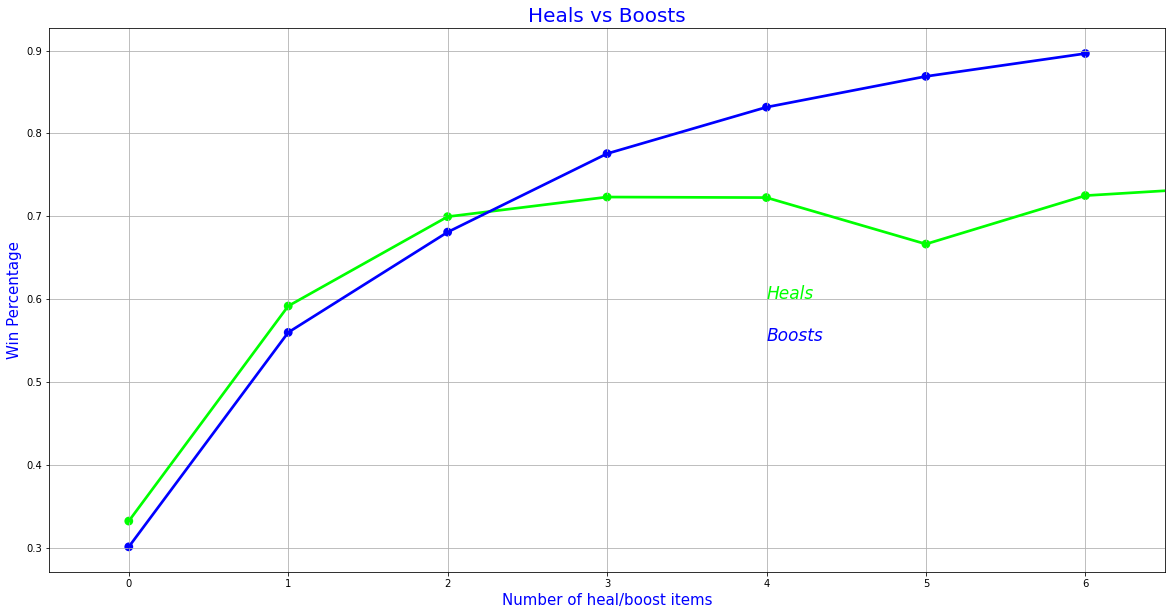

In [26]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

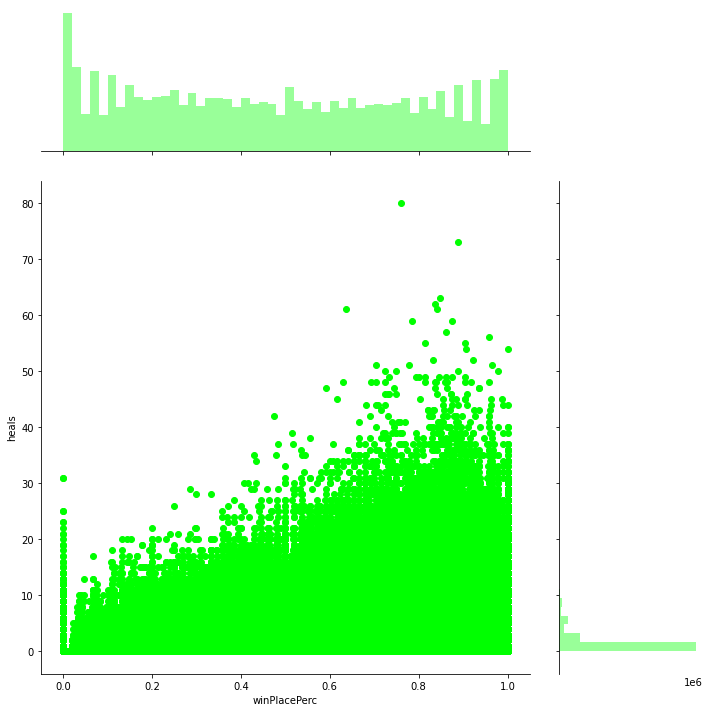

In [27]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="lime")
plt.show()

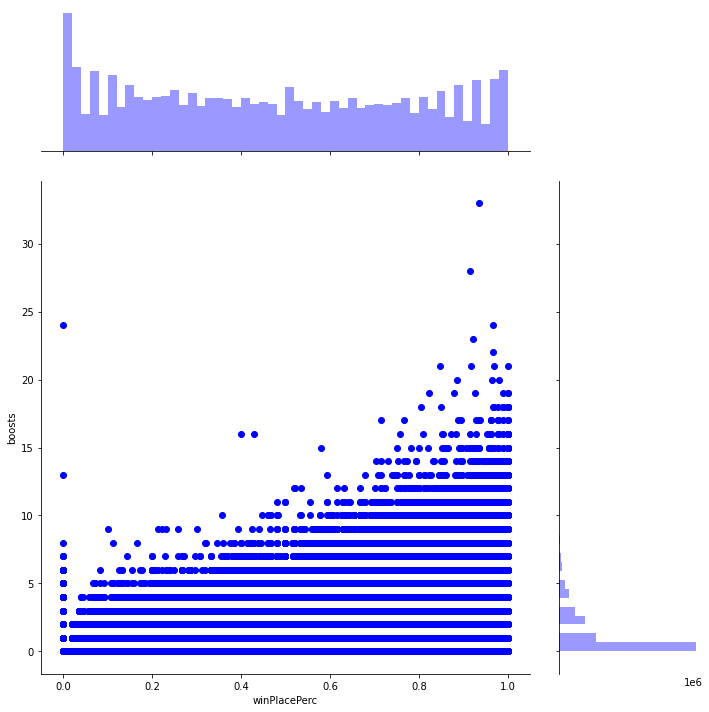

In [28]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

Healing and boosting both are majorly correlated with winning. Boosting is more

## Solo, Duos and Squads
There are 3 game modes in the game. One can play solo, or with a friend (duo), or with 3 other friends (squad). 100 players join the same server, so in the case of duos the max teams are 50 and in the case of squads the max teams are 25.

In [29]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

There are 709111 (15.95%) solo games, 3295326 (74.10%) duo games and 442529 (9.95%) squad games.


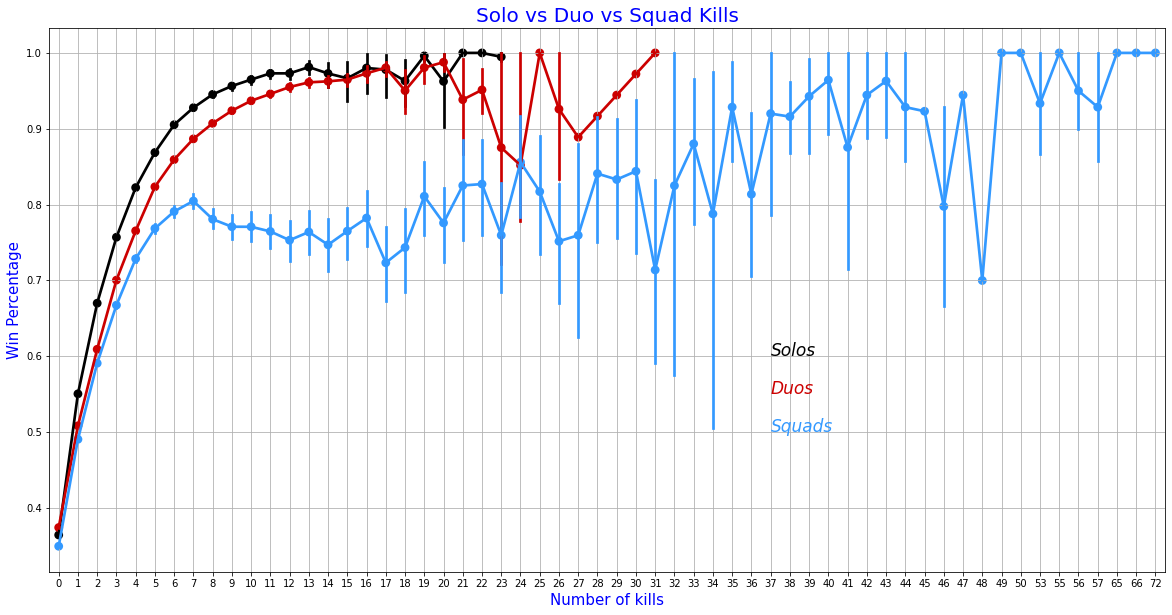

In [30]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

Somewhat strange yet logical that solo and duos behave the same but if you are playing in squad killing doesn't matter much to win. You can simply rely on the squad to do the work for you :)


The attribute DBNOs means enemy players knocked. A `knock` can happen only in duos or squads, because the teammates have the chance to `revive` the knocked player in a given time. So a knocked player can be revived or die. If he is revived, the next time he will be knocked, his teammates will have less time to revive him.

The attribute assist can also happen only in duos or squads. It generally means that the player had an involvement in a kill.

The attribute revive also happens in duos or squads.


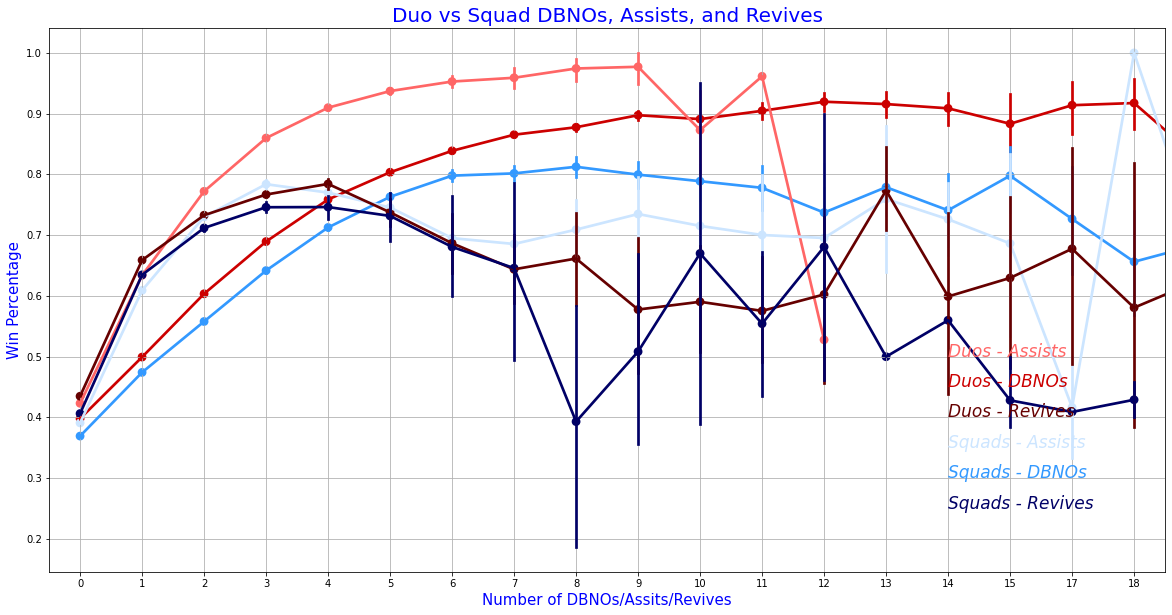

In [31]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

## Correlation among features

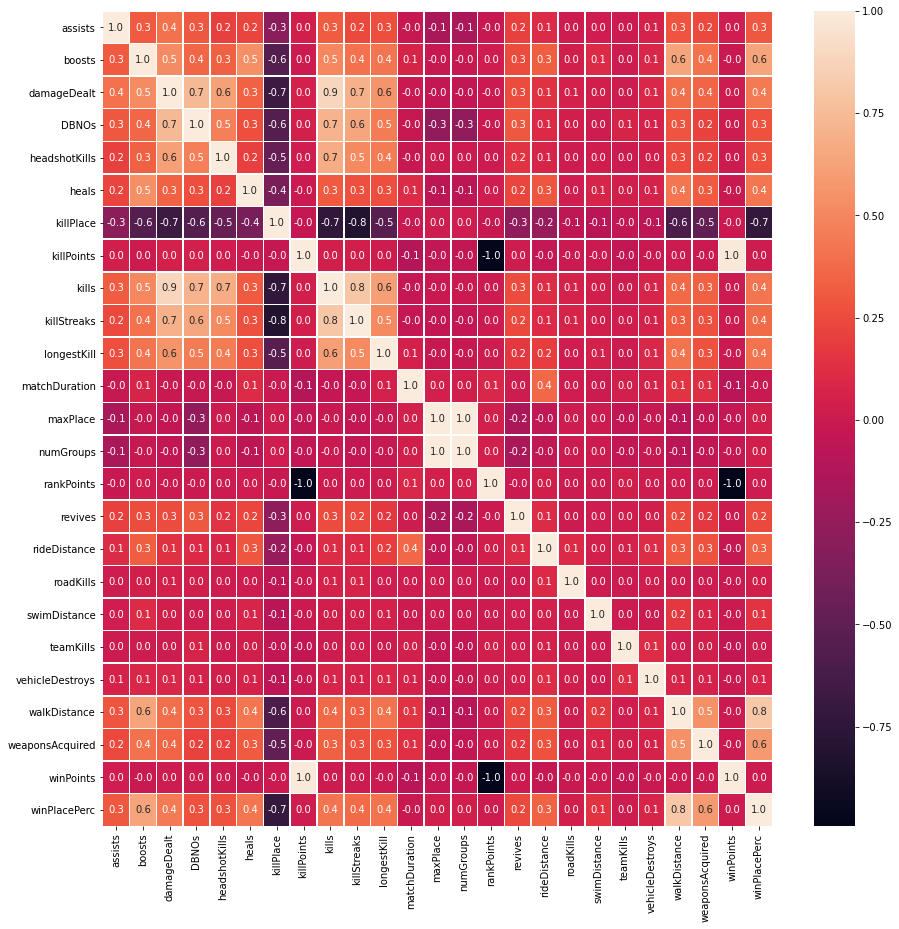

In [32]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()